In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lingua import Language, LanguageDetectorBuilder
from sacrebleu.metrics import BLEU
from datasets import load_dataset

/home/maksymiakovenko/miniconda3/envs/msc_quant1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = "../eval_results/flores/run_1"

In [3]:
langs = [
    ("fr", Language.FRENCH),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("hi", Language.HINDI),
]

languages = [
    Language.ENGLISH, 
    Language.FRENCH, 
    Language.SPANISH, 
    Language.UKRAINIAN, 
    Language.RUSSIAN, 
    Language.VIETNAMESE, 
    Language.INDONESIAN, 
    Language.CHINESE, 
    Language.HINDI,
]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code, column_name):
    def lang_filter(row):
        return detector.detect_language_of(str(row[column_name])) == l_code
    return lang_filter

quants = [
    ("hf", "16"),
    ("hf", "4"),
    ("rtn", "4"),
    ("awq", "4"),
    ("gptq", "4"),
]

bleu = BLEU(tokenize="flores101")

In [4]:
data_files = {
    "en": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.eng_Latn",
    "fr": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.fra_Latn",
    "ru": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.rus_Cyrl",
    "es": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.spa_Latn",
    "uk": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ukr_Cyrl",
    "vi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.vie_Latn",
    "id": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ind_Latn",
    "hi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.hin_Deva",
    "zh": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.cmn_Hans",
}

reference_data = load_dataset("text", data_files=data_files)

In [5]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

to_merge = None
for method, precision in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(l_code, "to"), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = f"{method} {precision}bit"
    if to_merge is None:
        to_merge = merge
    else:
        to_merge = pd.concat([to_merge, merge])

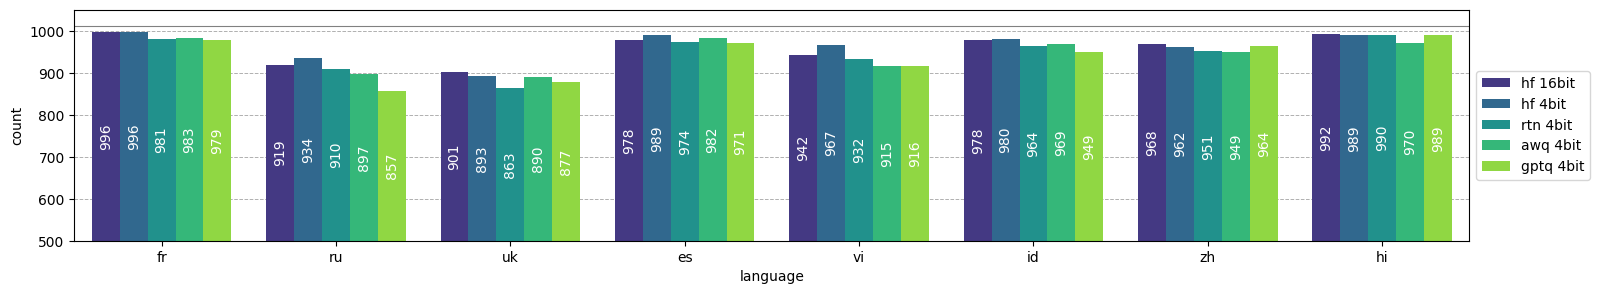

In [6]:
plt.figure(figsize=(18, 3), dpi=100)
plt.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
plt.ylim(500, 1050)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=to_merge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white")
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

In [7]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

from_merge = None
for method, precision in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(Language.ENGLISH, "from"), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = f"{method} {precision}bit"
    if from_merge is None:
        from_merge = merge
    else:
        from_merge = pd.concat([from_merge, merge])

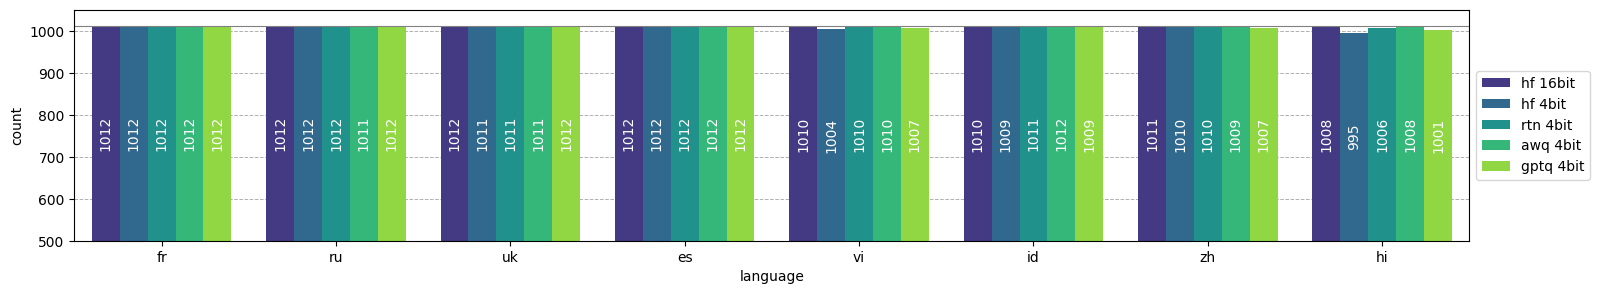

In [8]:
plt.figure(figsize=(18, 3), dpi=100)
plt.ylim(500, 1050)
plt.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=from_merge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white")
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

In [9]:
bleu_summary = None
columns = ["quant", "language", "BLEU", "misc", "direction"]

for method, precision in quants:
    ref_reverse = reference_data["en"]["text"]
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
        ref = reference_data[lang]["text"]

        bleu_to = bleu.corpus_score(data["to"].to_list(), [[line] for line in ref])
        bleu_from = bleu.corpus_score(data["from"].to_list(), [[line] for line in ref_reverse])

        line = pd.DataFrame([
            [f"{method} {precision}bit", lang, bleu_to.score, bleu_to, "to"], 
            [f"{method} {precision}bit", lang, bleu_from.score, bleu_from, "from"]
            ], columns=columns)
        
        if bleu_summary is None:
            bleu_summary = line
        else:
            bleu_summary = pd.concat([bleu_summary, line], axis=0, ignore_index=True)

bleu_summary

,quant,language,BLEU,misc,direction
0,hf 16bit,fr,37.160443,BLEU = 37.16 77.4/50.0/27.6/17.9 (BP = 1.000 r...,to
1,hf 16bit,fr,72.256765,BLEU = 72.26 96.3/88.5/64.0/50.0 (BP = 1.000 r...,from
2,hf 16bit,ru,13.924499,BLEU = 13.92 85.7/30.0/5.3/2.8 (BP = 1.000 rat...,to
3,hf 16bit,ru,43.343660,BLEU = 43.34 95.0/47.4/33.3/23.5 (BP = 1.000 r...,from
4,hf 16bit,uk,42.565922,BLEU = 42.57 95.8/56.5/31.8/19.0 (BP = 1.000 r...,to
...,...,...,...,...,...
75,gptq 4bit,id,24.556520,BLEU = 24.56 92.0/50.0/17.4/4.5 (BP = 1.000 ra...,from
76,gptq 4bit,zh,5.856458,BLEU = 5.86 50.0/8.7/2.3/1.2 (BP = 1.000 ratio...,to
77,gptq 4bit,zh,14.855427,BLEU = 14.86 100.0/40.9/4.8/2.5 (BP = 1.000 ra...,from
78,gptq 4bit,hi,14.216646,BLEU = 14.22 83.3/23.5/6.2/3.3 (BP = 1.000 rat...,to


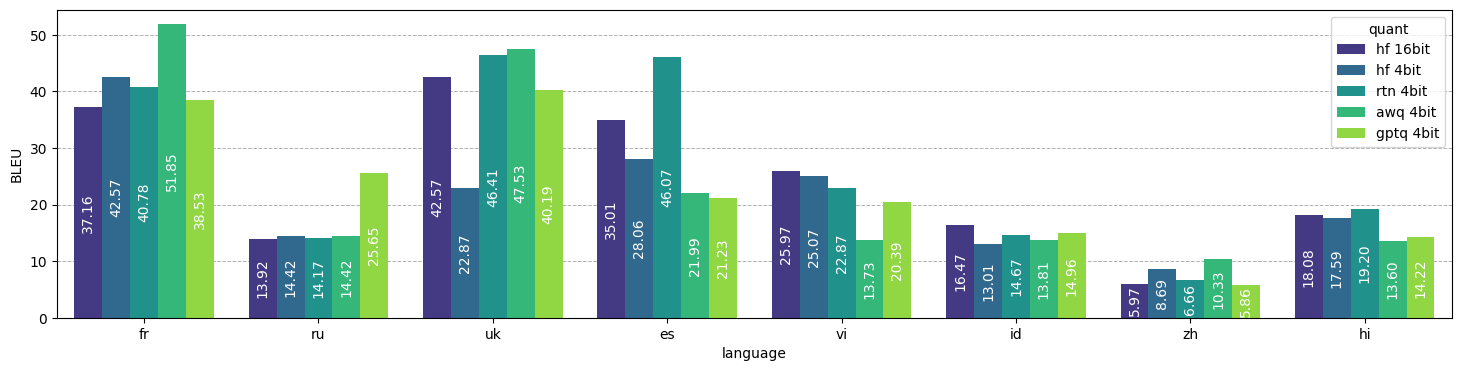

In [10]:
plt.figure(figsize=(18, 4), dpi=100)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary[bleu_summary["direction"]=="to"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

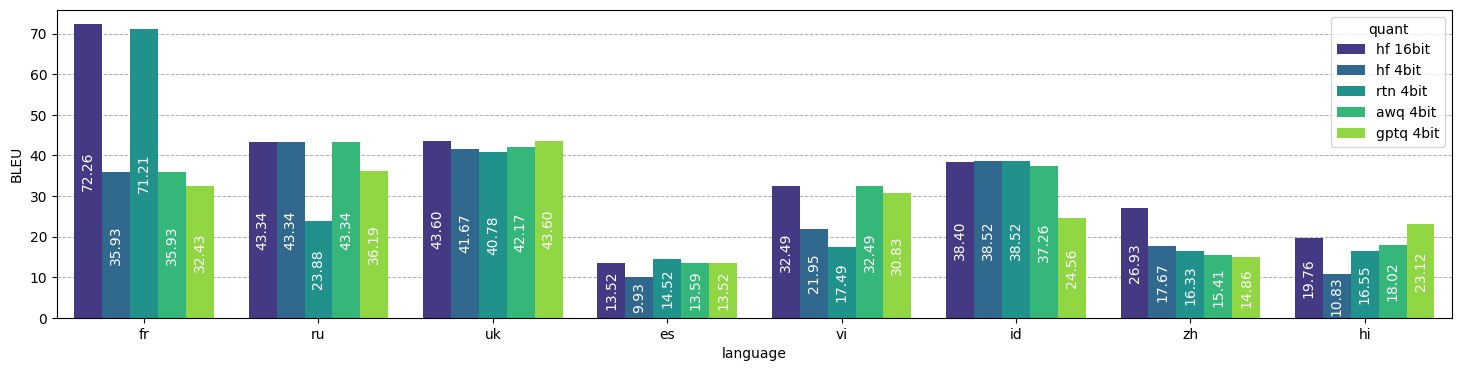

In [11]:
plt.figure(figsize=(18, 4), dpi=100)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary[bleu_summary["direction"]=="from"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
bleu_summary_avg = None
columns = ["quant", "language", "BLEU", "direction"]

for method, precision in quants:
    ref_reverse = reference_data["en"]["text"]
    for lang, l_code in langs:
        data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)

        ref = reference_data[lang]["text"]

        for n in range(len(ref_reverse)):
            bleu_to = bleu.corpus_score([data["to"].to_list()[n]], [[ref[n]]]).score
            bleu_from = bleu.corpus_score([data["from"].to_list()[n]], [[ref_reverse[n]]]).score

            line = pd.DataFrame([
                [f"{method} {precision}bit", lang, bleu_to, "to"], 
                [f"{method} {precision}bit", lang, bleu_from, "from"]
                ], columns=columns)
        
            if bleu_summary_avg is None:
                bleu_summary_avg = line
            else:
                bleu_summary_avg = pd.concat([bleu_summary_avg, line], axis=0, ignore_index=True)

bleu_summary_avg

,quant,language,BLEU,direction
0,hf 16bit,fr,26.848384,to
1,hf 16bit,fr,59.009730,from
2,hf 16bit,fr,56.976641,to
3,hf 16bit,fr,58.391361,from
4,hf 16bit,fr,13.011055,to
...,...,...,...,...
80955,gptq 4bit,hi,18.226811,from
80956,gptq 4bit,hi,2.776853,to
80957,gptq 4bit,hi,1.493370,from
80958,gptq 4bit,hi,2.400354,to


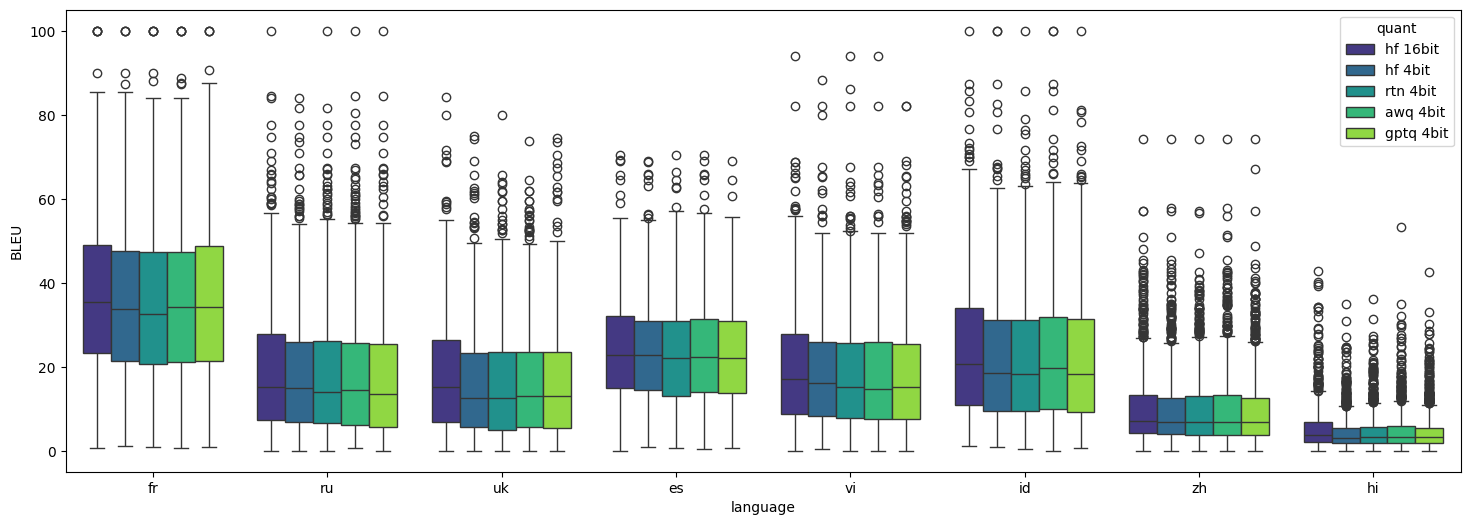

In [13]:
plt.figure(figsize=(18, 6), dpi=100)
ax = sns.boxplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="to"], saturation=1)
# for container in ax.containers:
#     labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
#     for label in labels:
#         label.set_rotation(90)

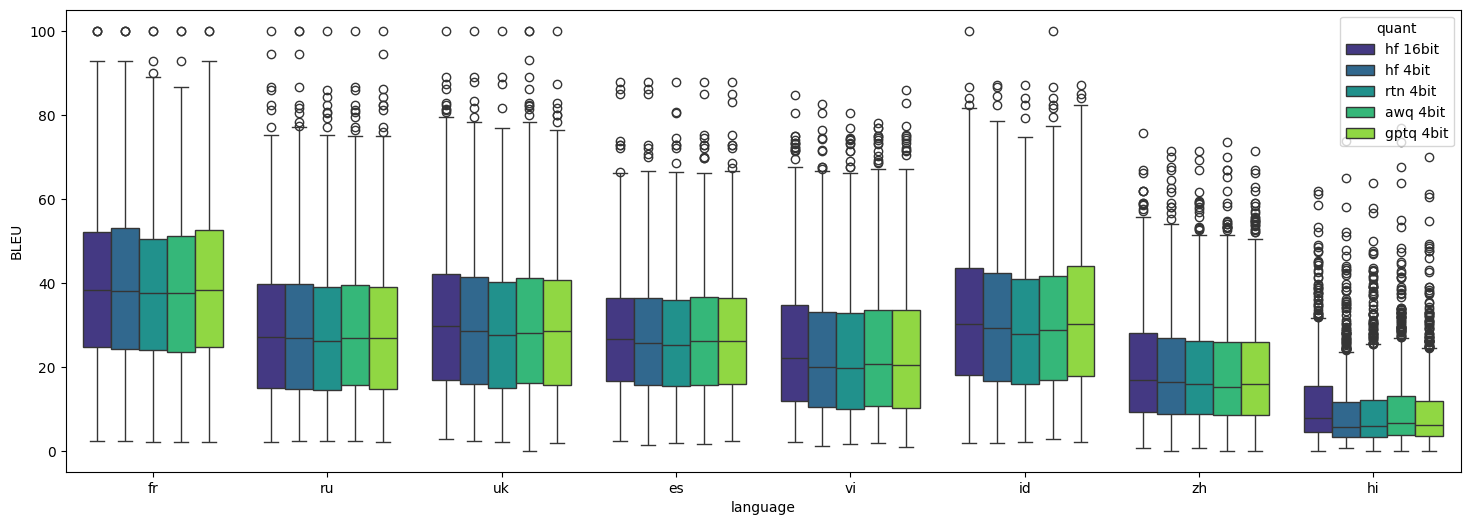

In [14]:
plt.figure(figsize=(18, 6), dpi=100)
ax = sns.boxplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="from"], saturation=1)
# for container in ax.containers:
#     labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
#     for label in labels:
#         label.set_rotation(90)

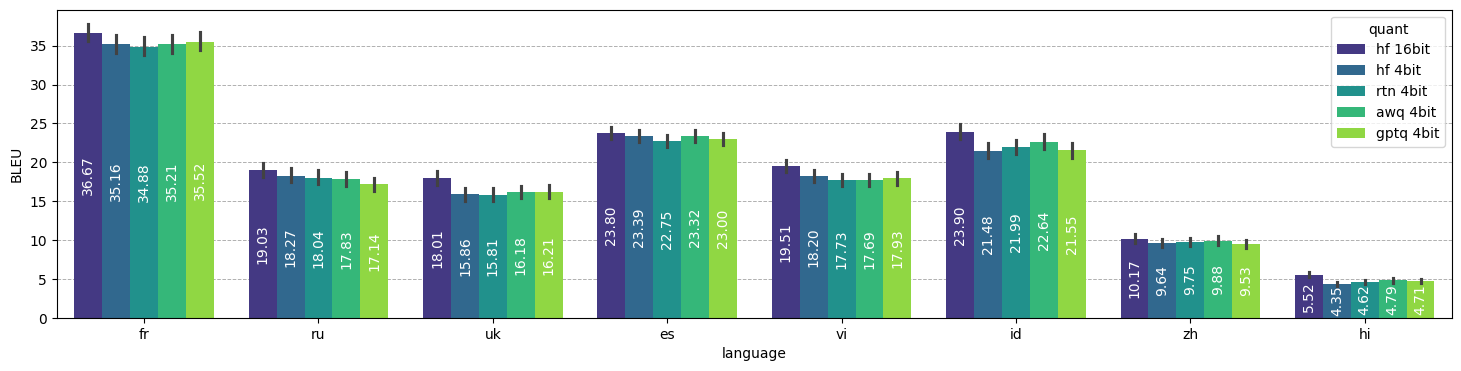

In [15]:
plt.figure(figsize=(18, 4), dpi=100)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="to"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

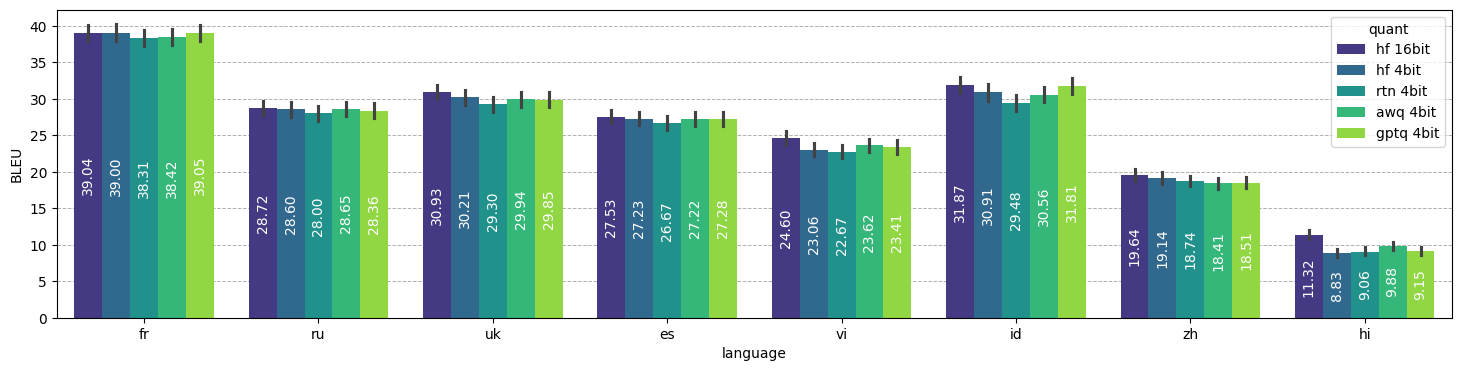

In [16]:
plt.figure(figsize=(18, 4), dpi=100)
ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="from"], saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)